# Investment Predictions Analysis 

### Problem Statement  :-  The area Stock market is something which is with lots of ups and downs. It can change in no time. Therefore we can use machine learning technique to identify market changes earlier than possible with traditional investment models.Using machine Learning models we can automate the investment predictions process.

Let's say we want to make money by buying stocks. Since we want to make money, we only want to buy stock on days when the price will go up (we're against shorting the stock). We'll create a machine learning algorithm to predict if the stock price will increase tomorrow. If the algorithm says that the price will increase, we'll buy stock. If the algorithm says that the price will go down, we won't do anything.

We want to maximize our true positives - days when the algorithm predicts that the price will go up, and it actually goes go up. Therefore, we'll be using precision as our error metric for our algorithm, which is true positives / (false positives + true positives). This will ensure that we minimize how much money we lose with false positives (days when we buy the stock, but the price actually goes down).

This means that we will have to accept a lot of false negatives - days when we predict that the price will go down, but it actually goes up. This is okay, since we'd rather minimize our potential losses than maximize our potential gains.

## Method

The steps we will going to follow:-

1)Web scraping historical stock prices from Yahoo finance

2)Explore the data

3)Setup the dataset to predict future prices using historical prices

4)Test a machine learning model

5)Setup a backtesting engine

6)Improve the accuracy of the model

In [1]:
#importing liberaries

import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

### 1) Web scraping Of historical prices

In [2]:
#webscaraping historcial data

ticker = '^GSPC'
period1 = int(time.mktime(datetime.datetime(2000,1,1,23,59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022,12,17,23,59).timetuple()))

query_url= f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval=1d&events=history&includeAdjustedClose=true'

data = pd.read_csv(query_url)
data.to_csv('s&p500.csv')

data["Date"] = data["Date"].astype("datetime64")
 
# Setting the Date as index
data = data.set_index("Date")

We have one row of data for each day that S&P500 was traded. Here are the columns:

Open - the price the stock opened at.

High - the highest price during the day

Low - the lowest price during the day

Close - the closing price on the trading day

Volume - how many shares were traded

Adj Close -  account all the factors that may have affected the stock price after the market hours

Stock doesn't trade every day (there is no trading on weekends and holidays), so some dates are missing.

In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


## 2) Exploring the data

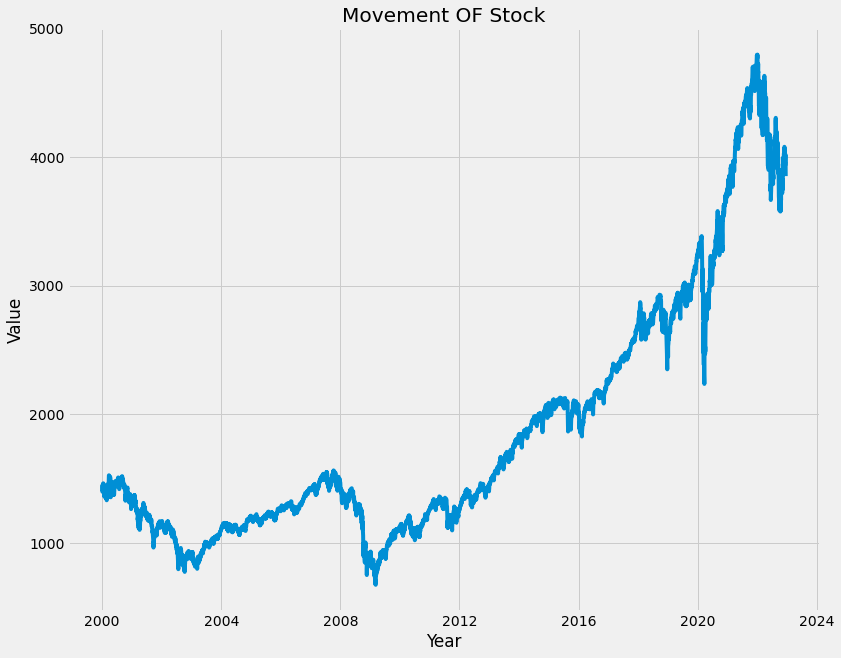

In [4]:
import matplotlib.pyplot as plt
 
# Using a inbuilt style to change
# the look and feel of the plot
plt.style.use("fivethirtyeight")
 
# setting figure size to 12, 10
plt.figure(figsize=(12, 10))
 
# Labelling the axes and setting title
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Movement OF Stock")
 
# plotting the "Close" column alone
plt.plot(data["Close"])

## 3)Setup the dataset to predict future prices using historical prices

Preparing the data so we can make predictions. We'll be predicting if the price will go up or down tomorrow based on data from today.

First, we'll identify a target that we're trying to predict. Our target will be if the price will go up or down tomorrow. If the price went up, the target will be 1 and if it went down, the target will be 0.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price. This ensures that we don't accidentally use data from the same day to make predictions.

Then, we'll combine both so we have our training data.

In [5]:
# Ensure we know the actual closing price
data_2 = data[["Close"]]
data_2= data_2.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data_2["Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

#checking data is imbalance or not
data_2["Target"].value_counts()

1.0    3085
0.0    2692
Name: Target, dtype: int64

In [6]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
data_prev = data.copy()
data_prev = data_prev.shift(1)
data_prev

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,9.318000e+08
2000-01-05,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1.009000e+09
2000-01-06,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1.085500e+09
2000-01-07,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1.092300e+09
...,...,...,...,...,...,...
2022-12-12,3954.169922,3977.020020,3933.040039,3934.379883,3934.379883,3.888260e+09
2022-12-13,3939.290039,3990.709961,3935.300049,3990.560059,3990.560059,3.904130e+09
2022-12-14,4069.379883,4100.959961,3993.030029,4019.649902,4019.649902,5.079360e+09


In [7]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data_2 = data_2.join(data_prev[predictors]).iloc[1:]

In [8]:
data_2.head(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
2000-01-04,1399.420044,0.0,1455.219971,9.318000e+08,1469.250000,1478.000000,1438.359985
2000-01-05,1402.109985,1.0,1399.420044,1.009000e+09,1455.219971,1455.219971,1397.430054
2000-01-06,1403.449951,1.0,1402.109985,1.085500e+09,1399.420044,1413.270020,1377.680054
2000-01-07,1441.469971,1.0,1403.449951,1.092300e+09,1402.109985,1411.900024,1392.099976
2000-01-10,1457.599976,1.0,1441.469971,1.225200e+09,1403.449951,1441.469971,1400.729980


## 4)Test a machine learning model

Creating a machine learning model to see how accurately we can predict the stock price.

Because we're dealing with time series data, we can't just use cross-validation to create predictions for the whole dataset. This will cause leakage where data from the future will be used to predict past prices. This doesn't match with the real world, and will make us think that our algorithm is much better than it actually is.

Instead, we'll split the data sequentially. We'll start off by predicting just the last 100 rows using the other rows.

We'll use a random forest classifier to generate our predictions. This is a good "default" model for a lot of applications, because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Creating a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data_2.iloc[:-100]
test = data_2.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [10]:
from sklearn.metrics import precision_score

# Evaluating error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.41304347826086957

<AxesSubplot:xlabel='Date'>

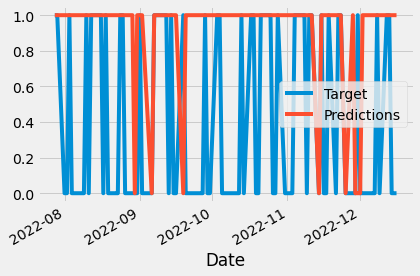

In [11]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

## 5)Setup a backtesting engine

Model isn't great, but luckily we can still improve it. Before we do that, let's figure out how to make predictions across the entire dataset, not just the last 100 rows. This will give us a more robust error estimate. The last 100 days may have has atypical market conditions or other issues that make error metrics on those days unrealistic for future predictions which are what we really care about.

To do this, we'll need to backtest. Backtesting ensures that we only use data from before the day that we're predicting. If we use data from after the day we're predicting, the algorithm is unrealistic (in the real world, you won't be able to use future data to predict that past!).

Our backtesting method will loop over the dataset, and train a model every 750 rows. We'll make it a function so we can avoid rewriting the code if we want to backtest again.

In the backtesting function, we will:

Split the training and test data
Train a model
Make predictions on the test data using predict_proba - this is because we want to really optimize for true positives. By default, the threshold for splitting 0/1 is .5, but we can set it to different values to tweak the precision. If we set it too high, we'll make fewer trades, but will have a lower potential for losses.

In [12]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [13]:
predictions = backtest(data_2, model, predictors)

In [14]:
predictions["Predictions"].value_counts()

0.0    4427
1.0     350
Name: Predictions, dtype: int64

In [15]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5114285714285715

## 6) Improve the accuracy of the model

The model isn't very accurate, but at least now we can make predictions across the entire history of the stock. For this model to be useful, we have to get it to predict more accurately.

Adding some more predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices. We'll also look at the ratios between different indicators.

In [16]:
weekly_mean = data_2.rolling(7).mean()
quarterly_mean = data_2.rolling(90).mean()
annual_mean = data_2.rolling(365).mean()
weekly_trend = data_2.shift(1).rolling(7).mean()["Target"]

In [17]:
data_2["weekly_mean"] = weekly_mean["Close"] / data_2["Close"]
data_2["quarterly_mean"] = quarterly_mean["Close"] / data_2["Close"]
data_2["annual_mean"] = annual_mean["Close"] / data_2["Close"]

data_2["annual_weekly_mean"] = data_2["annual_mean"] / data_2["weekly_mean"]
data_2["annual_quarterly_mean"] = data_2["annual_mean"] / data_2["quarterly_mean"]
data_2["weekly_trend"] = weekly_trend

data_2["open_close_ratio"] = data_2["Open"] / data_2["Close"]
data_2["high_close_ratio"] = data_2["High"] / data_2["Close"]
data_2["low_close_ratio"] = data_2["Low"] / data_2["Close"]

In [18]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data_2.iloc[365:], model, full_predictors)

In [26]:
data_2

,Actual_Close,Target,Close,Volume,Open,High,Low,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Date,,,,,,,,,,,,,,,,
2000-01-04,1399.420044,0.0,1455.219971,9.318000e+08,1469.250000,1478.000000,1438.359985,NaN,NaN,NaN,NaN,NaN,NaN,1.009641,1.015654,0.988414
2000-01-05,1402.109985,1.0,1399.420044,1.009000e+09,1455.219971,1455.219971,1397.430054,NaN,NaN,NaN,NaN,NaN,NaN,1.039874,1.039874,0.998578
2000-01-06,1403.449951,1.0,1402.109985,1.085500e+09,1399.420044,1413.270020,1377.680054,NaN,NaN,NaN,NaN,NaN,NaN,0.998082,1.007959,0.982576
2000-01-07,1441.469971,1.0,1403.449951,1.092300e+09,1402.109985,1411.900024,1392.099976,NaN,NaN,NaN,NaN,NaN,NaN,0.999045,1.006021,0.991913
2000-01-10,1457.599976,1.0,1441.469971,1.225200e+09,1403.449951,1441.469971,1400.729980,NaN,NaN,NaN,NaN,NaN,NaN,0.973624,1.000000,0.971737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,3990.560059,1.0,3934.379883,3.888260e+09,3954.169922,3977.020020,3933.040039,1.013780,0.995716,1.080746,1.066055,1.085395,0.142857,1.005030,1.010838,0.999659
2022-12-13,4019.649902,1.0,3990.560059,3.904130e+09,3939.290039,3990.709961,3935.300049,0.996429,0.981249,1.065305,1.069123,1.085662,0.285714,0.987152,1.000038,0.986152
2022-12-14,3995.320068,0.0,4019.649902,5.079360e+09,4069.379883,4100.959961,3993.030029,0.987368,0.973801,1.057369,1.070896,1.085816,0.428571,1.012372,1.020228,0.993378


In [19]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5628140703517588

In [20]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    4213
1.0     199
Name: Predictions, dtype: int64

<AxesSubplot:xlabel='Date'>

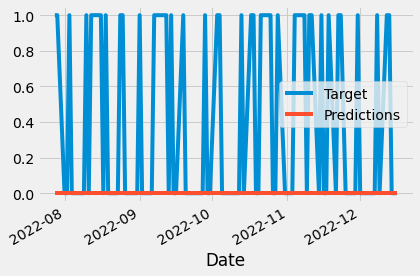

In [23]:
predictions.iloc[-100:].plot()

In [30]:
# Saving model to disk
pickle.dump(model, open('model.pkl','wb'))

# Loading model to compare the results
final_model = pickle.load(open('model.pkl','rb'))
print(backtest(data_2.iloc[365:], final_model, full_predictors))

            Target  Predictions
Date                           
2005-06-10     0.0          0.0
2005-06-13     1.0          0.0
2005-06-14     1.0          0.0
2005-06-15     1.0          0.0
2005-06-16     1.0          0.0
...            ...          ...
2022-12-12     1.0          0.0
2022-12-13     1.0          0.0
2022-12-14     0.0          0.0
2022-12-15     0.0          0.0
2022-12-16     0.0          0.0

[4412 rows x 2 columns]


In [29]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5628140703517588